# Anomaly Detection With Discord Discovery

<strong>Author:</strong> Tyler Marrs<br />
<strong>Date:</strong> January 18th 2019

This <a href="http://tylermarrs.com/posts/anomaly-detection-matrix-profile-discords/">notebook</a> shows how you can find discords within a matrix profile using a <a href="https://www.kaggle.com/boltzmannbrain/nab">NAB dataset</a>.  
We will be working with the NYC Taxi dataset.  

## Data Overview

The data consists of the number of taxi passengers from 2014-07-01 to 2015-01-31. There are 5 known anomalies during these periods:

* NYC Marathon - 2014-11-02
* Thanksgiving - 2014-11-27
* Christmas - 2014-12-25
* New Years - 2015-01-01
* Snow Blizzard - 2015-01-26 and 2015-01-27

I will see how close the anomaly detection is using matrix profiles.

# Compare Random Cut Forest
https://aws.amazon.com/ko/blogs/korea/use-the-built-in-amazon-sagemaker-random-cut-forest-algorithm-for-anomaly-detection/

# Data repository
https://github.com/numenta/NAB/tree/master/data

# Data exploration
https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [1]:
from matrixprofile import *
from matrixprofile.discords import discords

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

## Load Data

In [3]:
df = pd.read_csv('02_nyc_taxi.csv')

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df = df.set_index('timestamp').sort_index()

In [6]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


## Resample Hourly

Originally the dataset is within 30 minute increments.

In [7]:
df = df.resample('1H').sum()

In [8]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,18971
2014-07-01 01:00:00,10866
2014-07-01 02:00:00,6693
2014-07-01 03:00:00,4433
2014-07-01 04:00:00,4379


In [9]:
a = df.values.squeeze()

# subsequence length to compute the matrix profile
# since we have hourly measurements and want to find daily events,
# we will create a length of 24 - number of hours in a day
m = 24
profile = matrixProfile.stomp(a,m)

In [10]:
df['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
df['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)

## Plot Matrix Profile

Below is a plot of the hourly data and the matrix profile. Visually, you can see both motifs and discords. We are interested in finding the discords which are high peaks in the plot. A couple of periods jump out that seem close to Thanksgiving and the snow storm.

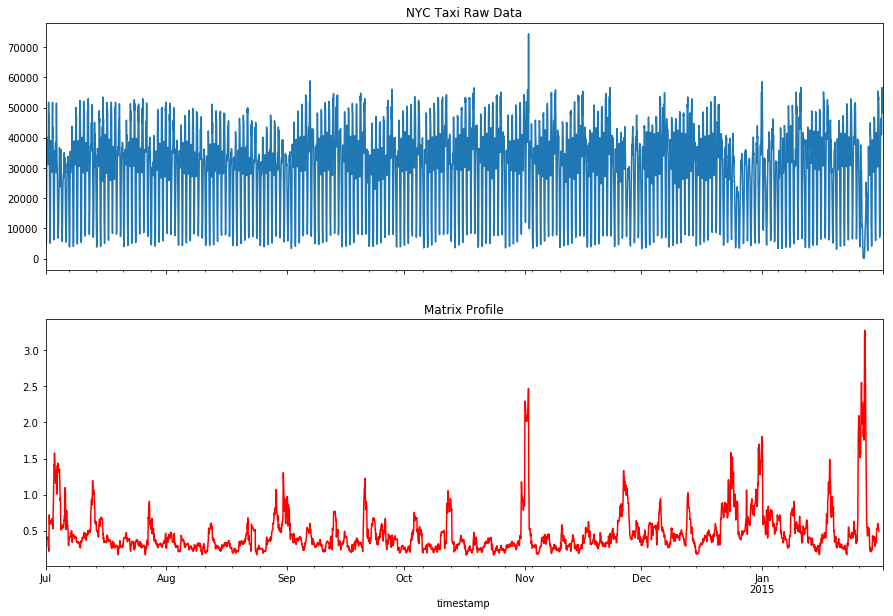

In [11]:
#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,10))
df['value'].plot(ax=ax1, title='NYC Taxi Raw Data')

#Plot the Matrix Profile
df['profile'].plot(ax=ax2, c='r', title='Matrix Profile')

# plt.savefig('02_NYC_Taxi_MP.png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [12]:
# exclude up to a day on the left and right side
ex_zone = 24

# we look for the 5 events specified in the data explaination
anoms = discords(df['profile'], ex_zone, k=5)

In [13]:
df.iloc[anoms]

,value,profile,profile_index
timestamp,,,
2015-01-27 09:00:00,3874,3.275818,129.0
2014-11-02 00:00:00,48219,2.468237,2304.0
2015-01-25 20:00:00,29503,2.094151,4824.0
2014-12-31 23:00:00,35978,1.803195,4653.0
2014-12-24 00:00:00,20646,1.581157,1466.0


We can see that the anomalies match up with the top 5 discords from the matrix profile.